


## Which tools & packages will we be using today?

Packages we're going to be using throughout this walkthrough will be

- `unsloth`: Efficient fine-tuning and inference for LLMs — Specifically we will be using:
    - `FastLanguageModel` module to optimize inference & fine-tuning
    - `get_peft_model` to enable LoRa (Low-Rank Adaptation) fine-tuning
- `peft`: Supports LoRA-based fine-tuning for large models.
- Different Hugging Face modules:
    - `transformers` from HuggingFace to work with our fine-tuning data and handle different model tasks
    - `trl` Transformer Reinforcement Learning from HuggingFace which allows for supervised fine-tuning of the model — we will use the `SFFTrainer` wrapper
    - `datasets` to fetch reasoning datasets from the Hugging Face Hub
- `torch`: Deep learning framework used for training
- `wandb`: Provides access to weights and biases for tracking our fine-tuning experiment 

## Before we get started — how to access the Hugging Face and Weights & Biases API

### Set GPU accelerator
We are using Kaggle Notebooks because we have access to free GPUs. To enable GPU access, press on Settings > Accelerator > GPU T4 x2

### How to access the Hugging Face API

1. Register to Huggin Face if you have not already
2. Go to [Hugging Face Tokens](https://huggingface.co/settings/tokens).
3. Click **"New Token"**.
4. Select **read/write** permissions if needed.
5. Copy your **API key**.

### Weights & Biases API key**
1. Sign up at [Weights & Biases](https://wandb.ai/site).
2. Go to [W&B Settings](https://wandb.ai/settings).
3. Copy your **API key** from the "API Keys" section.

### Add the API keys to Kaggle Notebooks
1. Press on Add-ons > Secrets
2. Add the API keys under `Hugging_Face_Token` and `wnb` respectively

You can now use this code to retrieve your API keys

```py
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hugging_face_token = user_secrets.get_secret("Hugging_Face_Token")
wnb_token = user_secrets.get_secret("wnb")
```

## Install relevant packages

In [2]:
%%capture

!pip install unsloth # install unsloth
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git # Also get the latest version Unsloth!

## Import all relevant packages throughout this walkthrough

In [4]:
# Modules for fine-tuning
from unsloth import FastLanguageModel
import torch # Import PyTorch
from trl import SFTTrainer # Trainer for supervised fine-tuning (SFT)
from unsloth import is_bfloat16_supported # Checks if the hardware supports bfloat16 precision
# Hugging Face modules
from huggingface_hub import login # Lets you login to API
from transformers import TrainingArguments # Defines training hyperparameters
from datasets import load_dataset # Lets you load fine-tuning datasets
# Import weights and biases
import wandb
# Import kaggle secrets
from kaggle_secrets import UserSecretsClient

## Create API keys and login to Hugging Face and Weights and Biases

In [5]:
# Initialize Hugging Face & WnB tokens
user_secrets = UserSecretsClient() # from kaggle_secrets import UserSecretsClient
hugging_face_token = user_secrets.get_secret("Hugging_Face_Token")
wnb_token = user_secrets.get_secret("wnb")

# Login to Hugging Face
login(hugging_face_token) # from huggingface_hub import login

# Login to WnB
wandb.login(key=wnb_token) # import wandb
run = wandb.init(
    project='Fine-tune-DeepSeek-R1-Distill-Llama-8B on Medical COT Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: Currently logged in as: longlethanh28 (longlethanh28-ho-chi-minh-university-of-science-). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Loading DeepSeek R1 and the Tokenizer

**What are we doing in this step?**

In this step, we **load the DeepSeek R1 model and its tokenizer** using `FastLanguageModel.from_pretrained()`. We also **configure key parameters** for efficient inference and fine-tuning. We will be using a distilled 8B version of R1 for faster computation.  

**Key parameters explained**
```py
max_seq_length = 2048  # Define the maximum sequence length a model can handle (i.e., number of tokens per input)
dtype = None  # Default data type (usually auto-detected)
load_in_4bit = True  # Enables 4-bit quantization – a memory-saving optimization
```

**Intuition behind 4-bit quantization**

Imagine compressing a **high-resolution image** to a smaller size—**it takes up less space but still looks good enough**. Similarly, **4-bit quantization reduces the precision of model weights**, making the model **smaller and faster while keeping most of its accuracy**. Instead of storing precise **32-bit or 16-bit numbers**, we compress them into **4-bit values**. This allows **large language models to run efficiently on consumer GPUs** without needing massive amounts of memory. 

In [8]:
# Set parameters
max_seq_length = 2048 # Define the maximum sequence length a model can handle (i.e. how many tokens can be processed at once)
dtype = None # Set to default 
load_in_4bit = True # Enables 4 bit quantization — a memory saving optimization 

# Load the DeepSeek R1 model and tokenizer using unsloth — imported using: from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/DeepSeek-R1-Distill-Llama-8B",  # Load the pre-trained DeepSeek R1 model (8B parameter version)
    max_seq_length=max_seq_length, # Ensure the model can process up to 2048 tokens at once
    dtype=dtype, # Use the default data type (e.g., FP16 or BF16 depending on hardware support)
    load_in_4bit=load_in_4bit, # Load the model in 4-bit quantization to save memory
    token=hugging_face_token, # Use hugging face token
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Testing DeepSeek R1 on a medical use-case before fine-tuning


### Defining a system prompt 
To create a prompt style for the model, we will define a system prompt and include placeholders for the question and response generation. The prompt will guide the model to think step-by-step and provide a logical, accurate response.

In [7]:
# Define a system prompt under prompt_style 
prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. 
Please answer the following medical question. 

### Question:
{}

### Response:
<think>{}"""

### Running inference on the model

In this step, we **test the DeepSeek R1 model** by providing a **medical question** and generating a response.  
The process involves the following steps:

1. **Define a test question** related to a medical case.
2. **Format the question using the structured prompt (`prompt_style`)** to ensure the model follows a logical reasoning process.
3. **Tokenize the input and move it to the GPU (`cuda`)** for faster inference.
4. **Generate a response using the model**, specifying key parameters like `max_new_tokens=1200` (limits response length).
5. **Decode the output tokens back into text** to obtain the final readable answer.

In [10]:
# Creating a test medical question for inference
question = """A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or 
              sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, 
              what would cystometry most likely reveal about her residual volume and detrusor contractions?"""

# Enable optimized inference mode for Unsloth models (improves speed and efficiency)
FastLanguageModel.for_inference(model)  # Unsloth has 2x faster inference!

# Format the question using the structured prompt (`prompt_style`) and tokenize it
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")  # Convert input to PyTorch tensor & move to GPU

# Generate a response using the model
outputs = model.generate(
    input_ids=inputs.input_ids, # Tokenized input question
    attention_mask=inputs.attention_mask, # Attention mask to handle padding
    max_new_tokens=1200, # Limit response length to 1200 tokens (to prevent excessive output)
    use_cache=True, # Enable caching for faster inference
)

# Decode the generated output tokens into human-readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the relevant response part (after "### Response:")
print(response[0].split("### Response:")[1])  


<think>
Okay, so I'm trying to figure out what cystometry would show for this 61-year-old woman. Let me break it down step by step.

First, the patient has a long history of involuntary urine loss when she coughs or sneezes. That makes me think about stress urinary incontinence, especially since she doesn't leak at night. So, the issue is probably happening during activities that increase abdominal pressure, like sneezing or coughing.

She underwent a gynecological exam and a Q-tip test. I'm not entirely sure what the Q-tip test entails, but I think it's used to assess urethral function. Maybe it measures how well the urethra closes. If the Q-tip test shows that the urethral closure is weak, especially during activities like coughing, that would support a diagnosis of stress incontinence.

Now, considering the findings from these tests, what would cystometry reveal? Cystometry is a diagnostic tool that fills the bladder and measures how much it holds before leaking (residual volume) a

>**Before starting fine-tuning — why are we fine-tuning in the first place?**
>
> Even without fine-tuning, our model successfully generated a chain of thought and provided reasoning before delivering the final answer. The reasoning process is encapsulated within the `<think>` `</think>` tags. So, why do we still need fine-tuning? The reasoning process, while detailed, was long-winded and not concise. Additionally, we want the final answer to be consistent in a certain style. 



## Fine-tuning step by step

### Step 1 — Update the system prompt 
We will slightly change the prompt style for processing the dataset by adding the third placeholder for the complex chain of thought column. `</think>`

In [9]:
# Updated training prompt style to add </think> tag 
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. 
Please answer the following medical question. 

### Question:
{}

### Response:
<think>
{}
</think>
{}"""


### Step 2 — Download the fine-tuning dataset and format it for fine-tuning

We will use the Medical O1 Reasoninng SFT found here on [Hugging Face](https://huggingface.co/datasets/FreedomIntelligence/medical-o1-reasoning-SFT). From the authors: This dataset is used to fine-tune HuatuoGPT-o1, a medical LLM designed for advanced medical reasoning. This dataset is constructed using GPT-4o, which searches for solutions to verifiable medical problems and validates them through a medical verifier.

In [11]:
# Download the dataset using Hugging Face — function imported using from datasets import load_dataset
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT","en", split = "train[0:500]",trust_remote_code=True) # Keep only first 500 rows
dataset

README.md:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

medical_o1_sft.json:   0%|          | 0.00/74.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25371 [00:00<?, ? examples/s]

Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 500
})

In [12]:
# Show an entry from the dataset
dataset[1]

{'Question': 'A 45-year-old man with a history of alcohol use, who has been abstinent for the past 10 years, presents with sudden onset dysarthria, shuffling gait, and intention tremors. Given this clinical presentation and history, what is the most likely diagnosis?',
 'Complex_CoT': "Alright, let’s break this down. We have a 45-year-old man here, who suddenly starts showing some pretty specific symptoms: dysarthria, shuffling gait, and those intention tremors. This suggests something's going wrong with motor control, probably involving the cerebellum or its connections.\n\nNow, what's intriguing is that he's had a history of alcohol use, but he's been off it for the past 10 years. Alcohol can do a number on the cerebellum, leading to degeneration, and apparently, the effects can hang around or even appear long after one stops drinking.\n\nAt first glance, these symptoms look like they could be some kind of chronic degeneration, maybe something like alcoholic cerebellar degeneration, 

In [16]:
dataset[0]

{'Question': 'A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, what would cystometry most likely reveal about her residual volume and detrusor contractions?',
 'Complex_CoT': "Okay, let's think about this step by step. There's a 61-year-old woman here who's been dealing with involuntary urine leakages whenever she's doing something that ups her abdominal pressure like coughing or sneezing. This sounds a lot like stress urinary incontinence to me. Now, it's interesting that she doesn't have any issues at night; she isn't experiencing leakage while sleeping. This likely means her bladder's ability to hold urine is fine when she isn't under physical stress. Hmm, that's a clue that we're dealing with something related to pressure rather than a bladder muscle problem. \n\nThe fact that she underwent a Q-tip test is intriguing too. This 

>**Next step is to structure the fine-tuning dataset according to train prompt style—why?**
>
> - Each question is paired with chain-of-thought reasoning and the final response.
> - Ensures every training example follows a consistent pattern.
> - Prevents the model from continuing beyond the expected response lengt by adding the EOS token.

In [15]:
# We need to format the dataset to fit our prompt training style 
EOS_TOKEN = tokenizer.eos_token  # Define EOS_TOKEN which the model when to stop generating text during training
EOS_TOKEN

'<｜end▁of▁sentence｜>'

In [17]:
# Define formatting prompt function
def formatting_prompts_func(examples):  # Takes a batch of dataset examples as input
    inputs = examples["Question"]       # Extracts the medical question from the dataset
    cots = examples["Complex_CoT"]      # Extracts the chain-of-thought reasoning (logical step-by-step explanation)
    outputs = examples["Response"]      # Extracts the final model-generated response (answer)
    
    texts = []  # Initializes an empty list to store the formatted prompts
    
    # Iterate over the dataset, formatting each question, reasoning step, and response
    for input, cot, output in zip(inputs, cots, outputs):  
        text = train_prompt_style.format(input, cot, output) + EOS_TOKEN  # Insert values into prompt template & append EOS token
        texts.append(text)  # Add the formatted text to the list

    return {
        "text": texts,  # Return the newly formatted dataset with a "text" column containing structured prompts
    }

In [18]:
# Update dataset formatting
dataset_finetune = dataset.map(formatting_prompts_func, batched = True)
dataset_finetune["text"][0]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

"Below is an instruction that describes a task, paired with an input that provides further context. \nWrite a response that appropriately completes the request. \nBefore answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.\n\n### Instruction:\nYou are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. \nPlease answer the following medical question. \n\n### Question:\nA 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, what would cystometry most likely reveal about her residual volume and detrusor contractions?\n\n### Response:\n<think>\nOkay, let's think about this step by step. There's a 61-year-old woman here who's been dealing with involuntary urine leakages whenever she's doing something that ups her ab

### Step 3 — Setting up the model using LoRA

**An intuitive explanation of LoRA** 

Large language models (LLMs) have **millions or even billions of weights** that determine how they process and generate text. When fine-tuning a model, we usually update all these weights, which **requires massive computational resources and memory**.

LoRA (**Low-Rank Adaptation**) allows to fine-tune efficiently by:

- Instead of modifying all weights, **LoRA adds small, trainable adapters** to specific layers.  
- These adapters **capture task-specific knowledge** while leaving the original model unchanged.  
- This reduces the number of trainable parameters **by more than 90%**, making fine-tuning **faster and more memory-efficient**.  

Think of an LLM as a **complex factory**. Instead of rebuilding the entire factory to produce a new product, LoRA **adds small, specialized tools** to existing machines. This allows the factory to adapt quickly **without disrupting its core structure**.

For a more technical explanation, check out this tutorial by [Sebastian Raschka](https://www.youtube.com/watch?v=rgmJep4Sb4&t).

Below, we will use the `get_peft_model()` function which stands for Parameter-Efficient Fine-Tuning — this function wraps the base model (`model`) with LoRA modifications, ensuring that only specific parameters are trained.

In [19]:
# Apply LoRA (Low-Rank Adaptation) fine-tuning to the model 
model_lora = FastLanguageModel.get_peft_model(
    model,
    r=16,  # LoRA rank: Determines the size of the trainable adapters (higher = more parameters, lower = more efficiency)
    target_modules=[  # List of transformer layers where LoRA adapters will be applied
        "q_proj",   # Query projection in the self-attention mechanism
        "k_proj",   # Key projection in the self-attention mechanism
        "v_proj",   # Value projection in the self-attention mechanism
        "o_proj",   # Output projection from the attention layer
        "gate_proj",  # Used in feed-forward layers (MLP)
        "up_proj",    # Part of the transformer’s feed-forward network (FFN)
        "down_proj",  # Another part of the transformer’s FFN
    ],
    lora_alpha=16,  # Scaling factor for LoRA updates (higher values allow more influence from LoRA layers)
    lora_dropout=0,  # Dropout rate for LoRA layers (0 means no dropout, full retention of information)
    bias="none",  # Specifies whether LoRA layers should learn bias terms (setting to "none" saves memory)
    use_gradient_checkpointing="unsloth",  # Saves memory by recomputing activations instead of storing them (recommended for long-context fine-tuning)
    random_state=3407,  # Sets a seed for reproducibility, ensuring the same fine-tuning behavior across runs
    use_rslora=False,  # Whether to use Rank-Stabilized LoRA (disabled here, meaning fixed-rank LoRA is used)
    loftq_config=None,  # Low-bit Fine-Tuning Quantization (LoFTQ) is disabled in this configuration
)

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Now, we initialize `SFTTrainer`, a supervised fine-tuning trainer from `trl` (Transformer Reinforcement Learning), to fine-tune our model efficiently on a dataset.

In [20]:
# Initialize the fine-tuning trainer — Imported using from trl import SFTTrainer
trainer = SFTTrainer(
    model=model_lora,  # The model to be fine-tuned
    tokenizer=tokenizer,  # Tokenizer to process text inputs
    train_dataset=dataset_finetune,  # Dataset used for training
    dataset_text_field="text",  # Specifies which field in the dataset contains training text
    max_seq_length=max_seq_length,  # Defines the maximum sequence length for inputs
    dataset_num_proc=2,  # Uses 2 CPU threads to speed up data preprocessing

    # Define training arguments
    args=TrainingArguments(
        per_device_train_batch_size=2,  # Number of examples processed per device (GPU) at a time
        gradient_accumulation_steps=4,  # Accumulate gradients over 4 steps before updating weights
        num_train_epochs=1, # Full fine-tuning run
        warmup_steps=5,  # Gradually increases learning rate for the first 5 steps
        max_steps=60,  # Limits training to 60 steps (useful for debugging; increase for full fine-tuning)
        learning_rate=2e-4,  # Learning rate for weight updates (tuned for LoRA fine-tuning)
        fp16=not is_bfloat16_supported(),  # Use FP16 (if BF16 is not supported) to speed up training
        bf16=is_bfloat16_supported(),  # Use BF16 if supported (better numerical stability on newer GPUs)
        logging_steps=10,  # Logs training progress every 10 steps
        optim="adamw_8bit",  # Uses memory-efficient AdamW optimizer in 8-bit mode
        weight_decay=0.01,  # Regularization to prevent overfitting
        lr_scheduler_type="linear",  # Uses a linear learning rate schedule
        seed=3407,  # Sets a fixed seed for reproducibility
        output_dir="outputs",  # Directory where fine-tuned model checkpoints will be saved
    ),
)


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

## Step 4 — Model training! 

This should take around 30 to 40 minutes — we can then check out our training results on Weights and Biases

In [23]:
# Start the fine-tuning process
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500 | Num Epochs = 2 | Total steps = 60
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
10,1.115800
20,1.059000
30,1.054100
40,0.897300
50,0.864200
60,0.825500


In [24]:
# Save the fine-tuned model
wandb.finish()

train/epoch,▁▂▄▅▇██▁▂▄▅▇██▁▂▄▅▇██
train/global_step,▁▂▄▅▇██▁▂▄▅▇██▁▂▄▅▇██
train/grad_norm,▅▃▂▁▁▂▂▂▃▃▃▃▅▅▆█▇▇
train/learning_rate,█▇▅▄▂▁█▇▅▄▂▁█▇▅▄▂▁
train/loss,█▅▄▄▄▄▄▄▄▃▃▃▃▃▂▁▁▁
total_flos,4.008346716644966e+16
train/epoch,1.896
train/global_step,60
train/grad_norm,0.57024
train/learning_rate,0
train/loss,0.8255


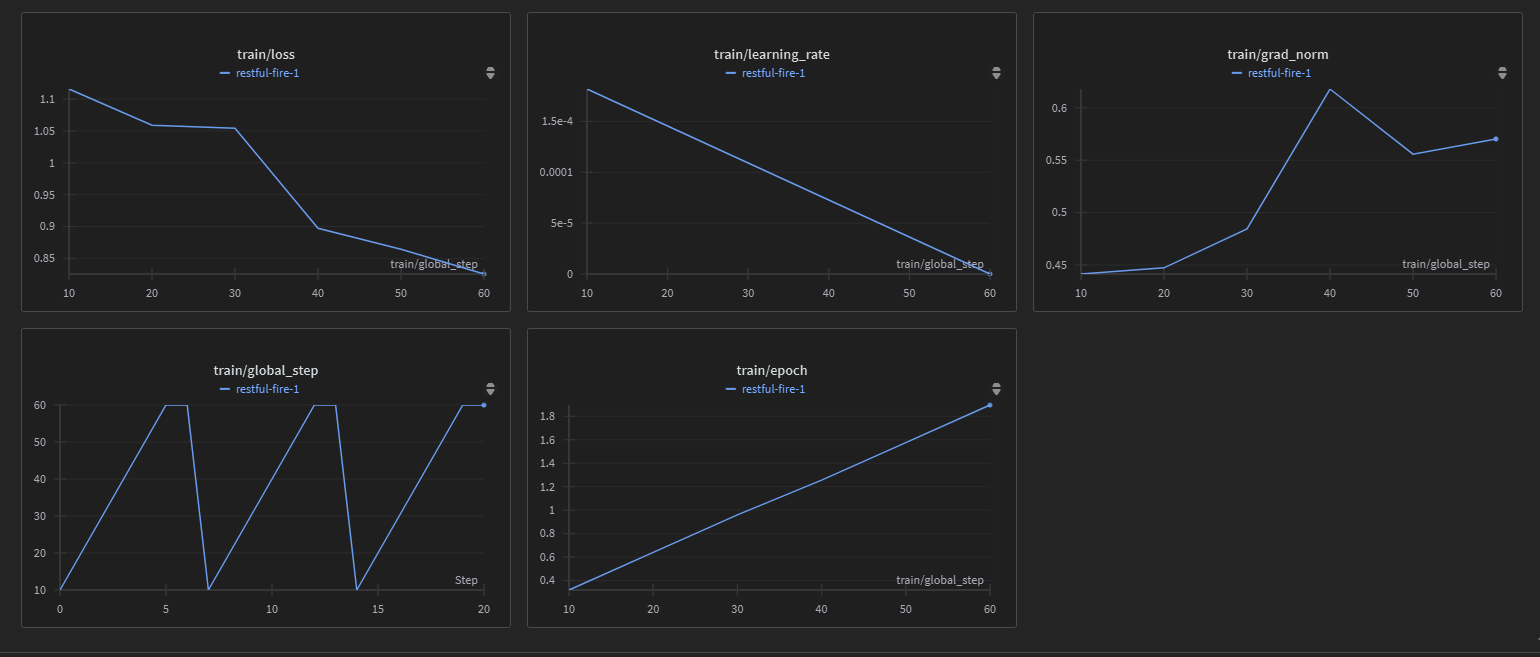

## Step 5 — Run model inference after fine-tuning

In [25]:
question = """A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing 
              but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, 
              what would cystometry most likely reveal about her residual volume and detrusor contractions?"""

# Load the inference model using FastLanguageModel (Unsloth optimizes for speed)
FastLanguageModel.for_inference(model_lora)  # Unsloth has 2x faster inference!

# Tokenize the input question with a specific prompt format and move it to the GPU
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

# Generate a response using LoRA fine-tuned model with specific parameters
outputs = model_lora.generate(
    input_ids=inputs.input_ids,          # Tokenized input IDs
    attention_mask=inputs.attention_mask, # Attention mask for padding handling
    max_new_tokens=1200,                  # Maximum length for generated response
    use_cache=True,                        # Enable cache for efficient generation
)

# Decode the generated response from tokenized format to readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the model's response part after "### Response:"
print(response[0].split("### Response:")[1])


<think>
Alright, let's think about this step by step. We have a 61-year-old woman who's been dealing with involuntary urine leakage when she's doing things like coughing or sneezing. But, interestingly, she doesn't seem to have any issues at night. That's a key detail because it might point us away from something like stress urinary incontinence, which often happens when you're up and around but can leak when you're lying down.

Now, when they did the gynecological exam and the Q-tip test, what does that mean for her? The Q-tip test is usually used to see if there's urethral obstruction. If it's positive, it might mean there's something blocking the urethra. But if it's negative, then maybe there's nothing blocking there. Hmm, I wonder what this test tells us about her urethra.

Given all this, what are we really dealing with? Well, she's leaking urine involuntarily during activities, but she's not leaking at night. That sounds a lot like stress urinary incontinence. It's like her bla

In [26]:
question = """A 59-year-old man presents with a fever, chills, night sweats, and generalized fatigue, 
              and is found to have a 12 mm vegetation on the aortic valve. Blood cultures indicate gram-positive, catalase-negative, 
              gamma-hemolytic cocci in chains that do not grow in a 6.5% NaCl medium. 
              What is the most likely predisposing factor for this patient's condition?"""

# Tokenize the input question with a specific prompt format and move it to the GPU
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

# Generate a response using LoRA fine-tuned model with specific parameters
outputs = model_lora.generate(
    input_ids=inputs.input_ids,          # Tokenized input IDs
    attention_mask=inputs.attention_mask, # Attention mask for padding handling
    max_new_tokens=1200,                  # Maximum length for generated response
    use_cache=True,                        # Enable cache for efficient generation
)

# Decode the generated response from tokenized format to readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the model's response part after "### Response:"
print(response[0].split("### Response:")[1])


<think>
Alright, let's break this down. We've got a 59-year-old man with symptoms like a fever, chills, night sweats, and feeling really tired. That sounds like a possible infection, maybe even something chronic. And when you add a vegetation on the aortic valve into the mix, it really starts sounding like something like endocarditis. 

Now, let's think about what kind of bacteria we're dealing with here. The blood cultures came back showing us gram-positive, catalase-negative, gamma-hemolytic cocci in chains. Hmm, that sounds a lot like what you'd see with Streptococcus species, specifically Streptococcus viridans. 

Oh, and it doesn't grow in 6.5% NaCl. That's an important detail because it helps us differentiate from other types of streptococci, like those that are encapsulated, which do grow in that medium. So, yeah, Streptococcus viridans fits like a glove here. 

Now, why would this guy end up with endocarditis in the first place? Well, there are a few things that can predispose

In [27]:
import shutil
shutil.make_archive("/kaggle/working/my_finetuned_model", 'zip', "/kaggle/working/model_lora")


'/kaggle/working/my_finetuned_model.zip'